Missing values in each variable:
Crowded dwellings                        0
No piped water                           0
Using public healthcare facilities       0
Poor health status                       0
Failed to find healthcare when needed    0
No medical insurance                     0
Household hunger risk                    0
Benefiting from school feeding scheme    0
UTFVI                                    0
LST                                      0
NDVI                                     0
NDBI__mean                               0
concern_he                               0
cancer_pro                               0
diabetes_p                               0
pneumonia_                               0
heart_dise                               0
hypertensi                               0
hiv_prop                                 0
tb_prop                                  0
covid_prop                               0
60_plus_pr                               0
dtype: int64
Missing 

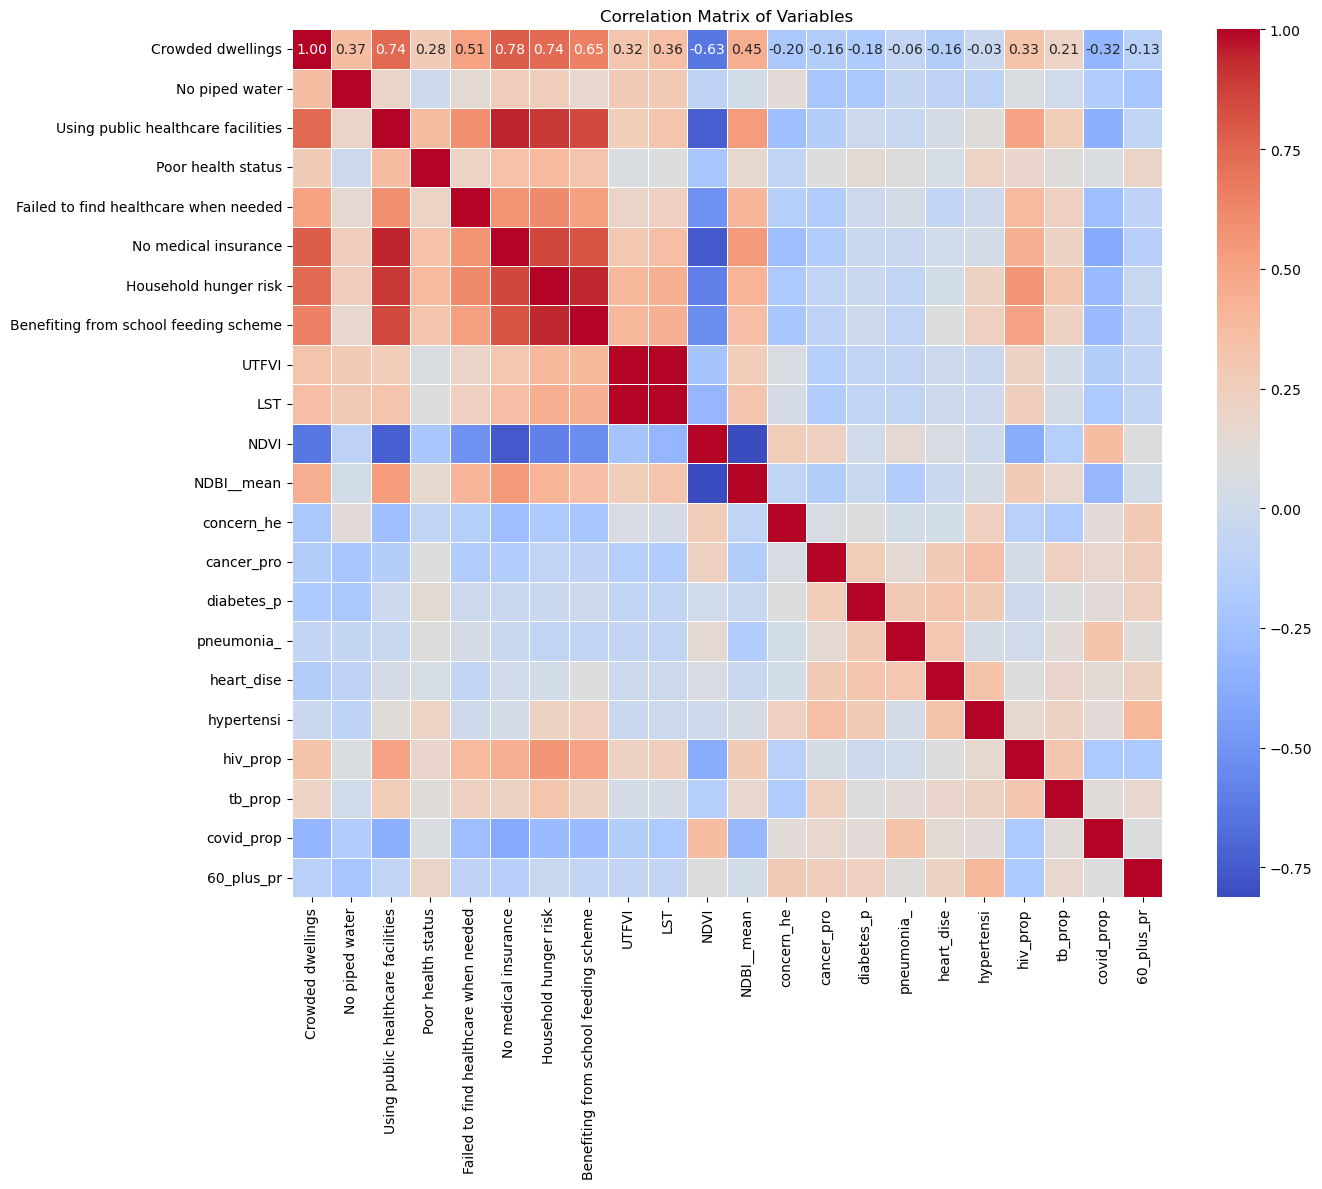

Number of components explaining 90% variance: 13


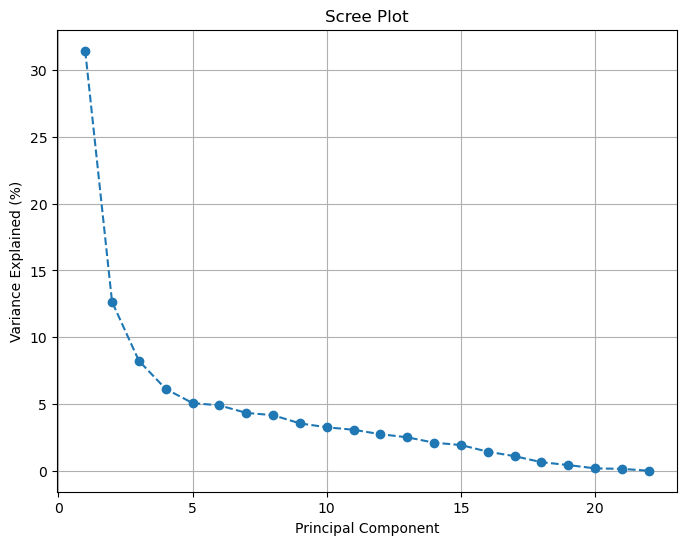

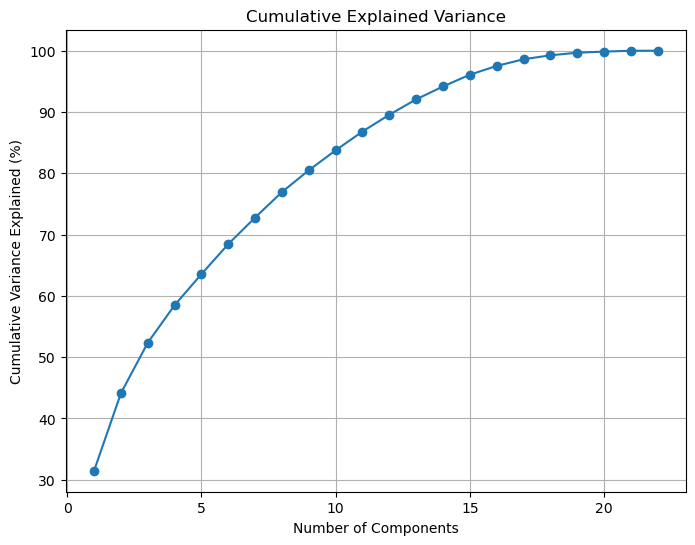

                                            PC1       PC2       PC3
Crowded dwellings                     -0.310918 -0.056326  0.042989
No piped water                        -0.112483 -0.191059 -0.256855
Using public healthcare facilities    -0.352105  0.076542  0.123018
Poor health status                    -0.132356  0.230866  0.032982
Failed to find healthcare when needed -0.256746  0.016471  0.106190
No medical insurance                  -0.351050  0.026580  0.109180
Household hunger risk                 -0.349229  0.106490 -0.022795
Benefiting from school feeding scheme -0.326710  0.106338 -0.034114
UTFVI                                 -0.181751 -0.107997 -0.580553
LST                                   -0.205122 -0.105668 -0.552797
NDVI                                   0.300604  0.033316 -0.167401
NDBI__mean                            -0.240871 -0.017188  0.069503
concern_he                             0.098298  0.061004 -0.391323
cancer_pro                             0.077956 

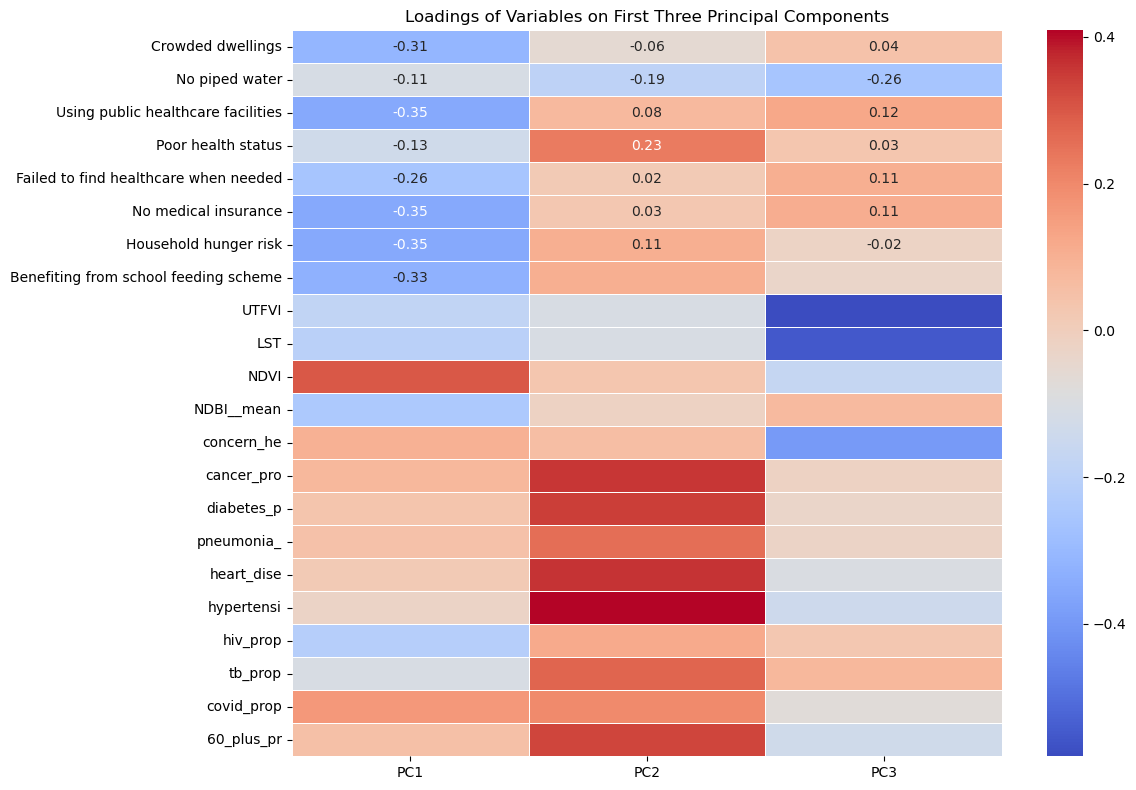

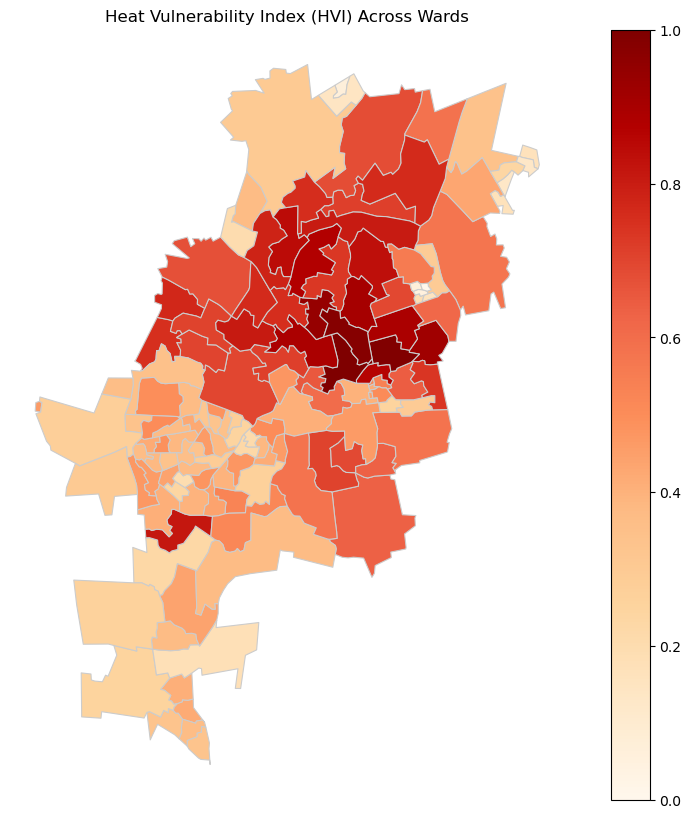

C:\Users\CraigParker\AppData\Local\Temp\ipykernel_32152\2839575112.py:143: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


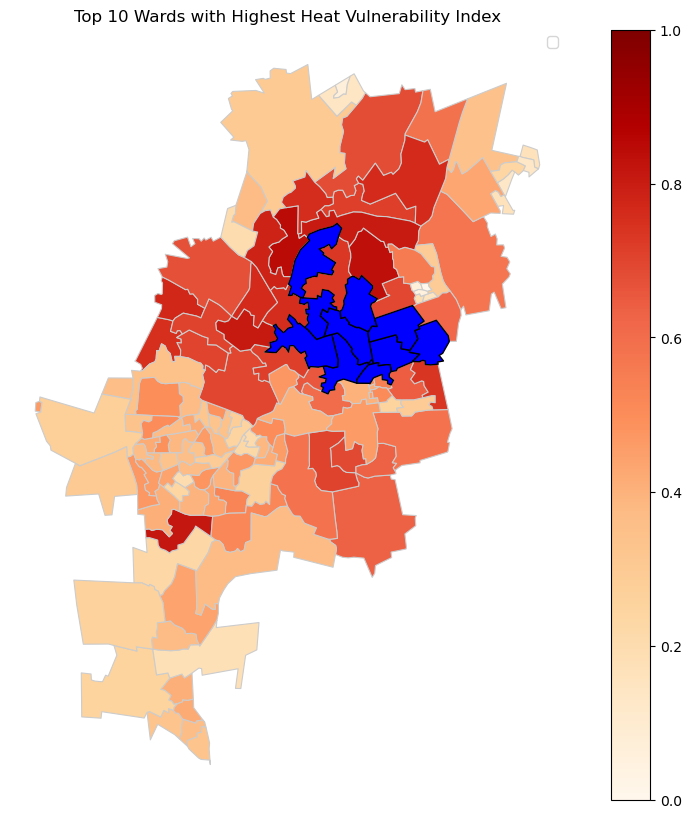

Top 10 Vulnerable Wards:
      WardID_  HVI_weighted_standardized
86   79800087                   1.000000
73   79800073                   0.995599
116  79800117                   0.984097
98   79800099                   0.944253
72   79800072                   0.921102
89   79800090                   0.905557
74   79800074                   0.893363
87   79800088                   0.892488
103  79800104                   0.876396
67   79800067                   0.865001


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the GeoJSON file using GeoPandas
file_path = 'HVI_with_columnames.geojson'  # Replace with your actual file path
gdf = gpd.read_file(file_path)

# Convert multi-part geometries into single-part geometries if necessary
gdf = gdf.explode(index_parts=False).reset_index(drop=True)

# Display the first few rows
gdf.head()

variables = [
    'Crowded dwellings', 'No piped water', 'Using public healthcare facilities', 'Poor health status',
    'Failed to find healthcare when needed', 'No medical insurance', 'Household hunger risk',
    'Benefiting from school feeding scheme', 'UTFVI', 'LST', 'NDVI', 'NDBI__mean', 'concern_he',
    'cancer_pro', 'diabetes_p', 'pneumonia_', 'heart_dise', 'hypertensi', 'hiv_prop', 'tb_prop',
    'covid_prop', '60_plus_pr'
]

# Check for missing values
missing_values = gdf[variables].isnull().sum()
print("Missing values in each variable:")
print(missing_values)

# Convert variables to numeric if necessary
for var in variables:
    gdf[var] = pd.to_numeric(gdf[var], errors='coerce')

# Re-check for missing values after conversion
missing_values = gdf[variables].isnull().sum()
print("Missing values after type conversion:")
print(missing_values)

# For simplicity, drop rows with missing values
gdf_clean = gdf.dropna(subset=variables).copy()
print(f"Number of rows after dropping missing values: {gdf_clean.shape[0]}")

# Descriptive statistics of the variables
desc_stats = gdf_clean[variables].describe()
print(desc_stats)

# Save the descriptive statistics to a CSV file
desc_stats.to_csv('Descriptive_Statistics.csv')

# Compute the correlation matrix
corr_matrix = gdf_clean[variables].corr()

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Variables')
plt.tight_layout()
plt.show()

# Save the correlation matrix
corr_matrix.to_csv('Correlation_Matrix.csv')

# Standardize the variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(gdf_clean[variables])

# Initialize PCA
pca = PCA(n_components=None)
principal_components = pca.fit_transform(scaled_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Determine the number of components explaining 90% variance
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components explaining 90% variance: {n_components}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance * 100, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.grid(True)
plt.show()

# Get the loadings (coefficients)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(explained_variance))], index=variables)

# Display the loadings for the first three principal components
loadings_first_three = loadings[['PC1', 'PC2', 'PC3']]
print(loadings_first_three)

# Heatmap of loadings for the first three PCs
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_first_three, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Loadings of Variables on First Three Principal Components')
plt.tight_layout()
plt.show()

# Add PC1 to the GeoDataFrame
gdf_clean['HVI_PC1'] = principal_components[:, 0]

# Standardize HVI_PC1
gdf_clean['HVI_PC1_standardized'] = (gdf_clean['HVI_PC1'] - gdf_clean['HVI_PC1'].min()) / (gdf_clean['HVI_PC1'].max() - gdf_clean['HVI_PC1'].min())

# Use the first n_components that explain 90% variance
weights = explained_variance[:n_components]
gdf_clean['HVI_weighted'] = principal_components[:, :n_components] @ weights

# Standardize the weighted HVI
gdf_clean['HVI_weighted_standardized'] = (gdf_clean['HVI_weighted'] - gdf_clean['HVI_weighted'].min()) / (gdf_clean['HVI_weighted'].max() - gdf_clean['HVI_weighted'].min())

# Plot HVI across wards
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(column='HVI_weighted_standardized', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Heat Vulnerability Index (HVI) Across Wards')
ax.set_axis_off()
plt.show()

# Identify top 10 vulnerable wards
top_10_wards = gdf_clean.nlargest(10, 'HVI_weighted_standardized')

# Plot the map with top 10 wards highlighted
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.plot(column='HVI_weighted_standardized', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
top_10_wards.plot(ax=ax, color='blue', edgecolor='black', linewidth=1, label='Top 10 Vulnerable Wards')
plt.title('Top 10 Wards with Highest Heat Vulnerability Index')
ax.set_axis_off()
plt.legend()
plt.show()

# Display top 10 wards
print("Top 10 Vulnerable Wards:")
print(top_10_wards[['WardID_', 'HVI_weighted_standardized']])

Missing values in each variable:
Crowded dwellings                        0
No piped water                           0
Using public healthcare facilities       0
Poor health status                       0
Failed to find healthcare when needed    0
No medical insurance                     0
Household hunger risk                    0
Benefiting from school feeding scheme    0
UTFVI                                    0
LST                                      0
NDVI                                     0
NDBI__mean                               0
concern_he                               0
cancer_pro                               0
diabetes_p                               0
pneumonia_                               0
heart_dise                               0
hypertensi                               0
hiv_prop                                 0
tb_prop                                  0
covid_prop                               0
60_plus_pr                               0
dtype: int64
Missing 

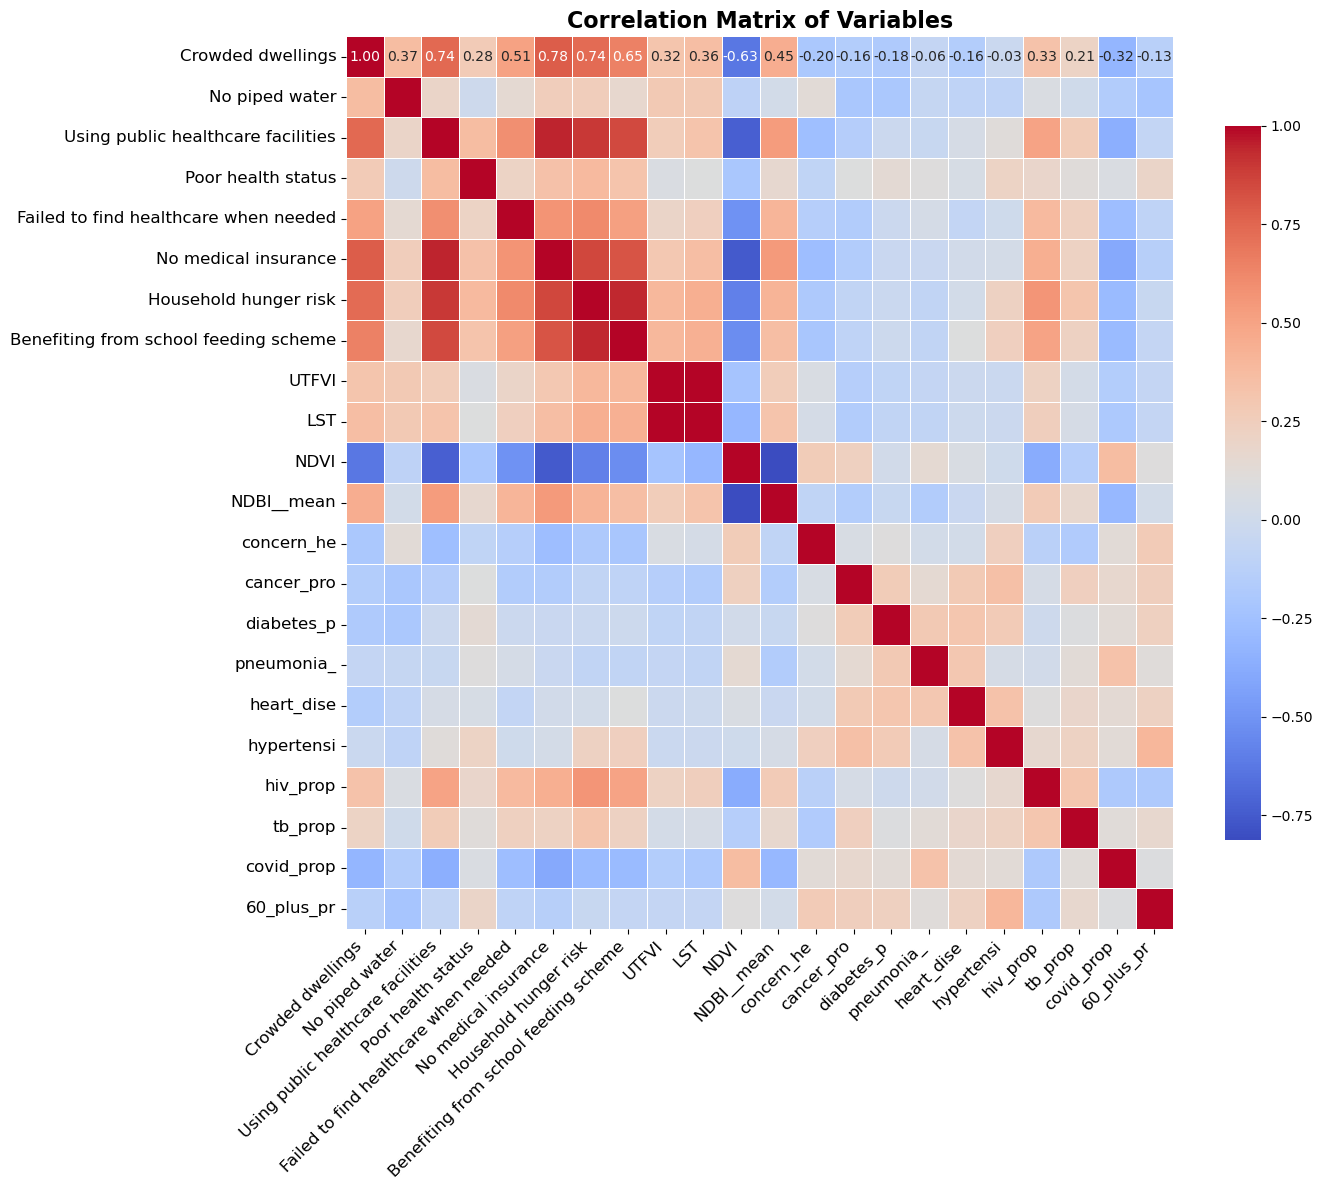

Number of components explaining 90% variance: 13


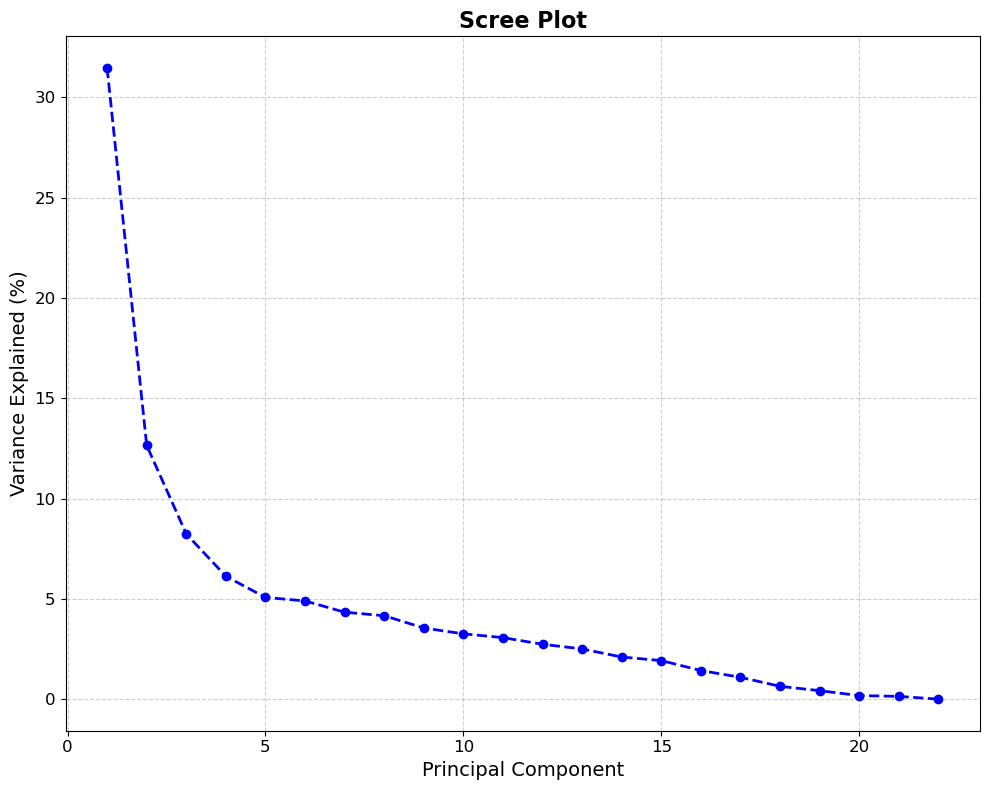

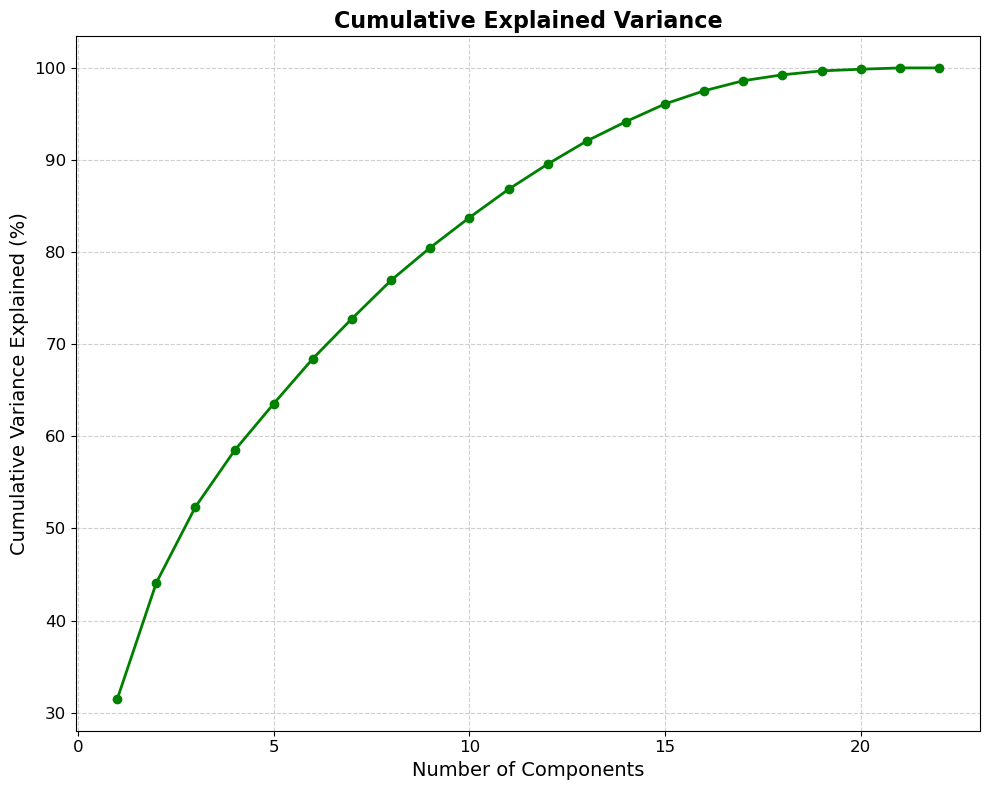

                                            PC1       PC2       PC3
Crowded dwellings                     -0.310918 -0.056326  0.042989
No piped water                        -0.112483 -0.191059 -0.256855
Using public healthcare facilities    -0.352105  0.076542  0.123018
Poor health status                    -0.132356  0.230866  0.032982
Failed to find healthcare when needed -0.256746  0.016471  0.106190
No medical insurance                  -0.351050  0.026580  0.109180
Household hunger risk                 -0.349229  0.106490 -0.022795
Benefiting from school feeding scheme -0.326710  0.106338 -0.034114
UTFVI                                 -0.181751 -0.107997 -0.580553
LST                                   -0.205122 -0.105668 -0.552797
NDVI                                   0.300604  0.033316 -0.167401
NDBI__mean                            -0.240871 -0.017188  0.069503
concern_he                             0.098298  0.061004 -0.391323
cancer_pro                             0.077956 

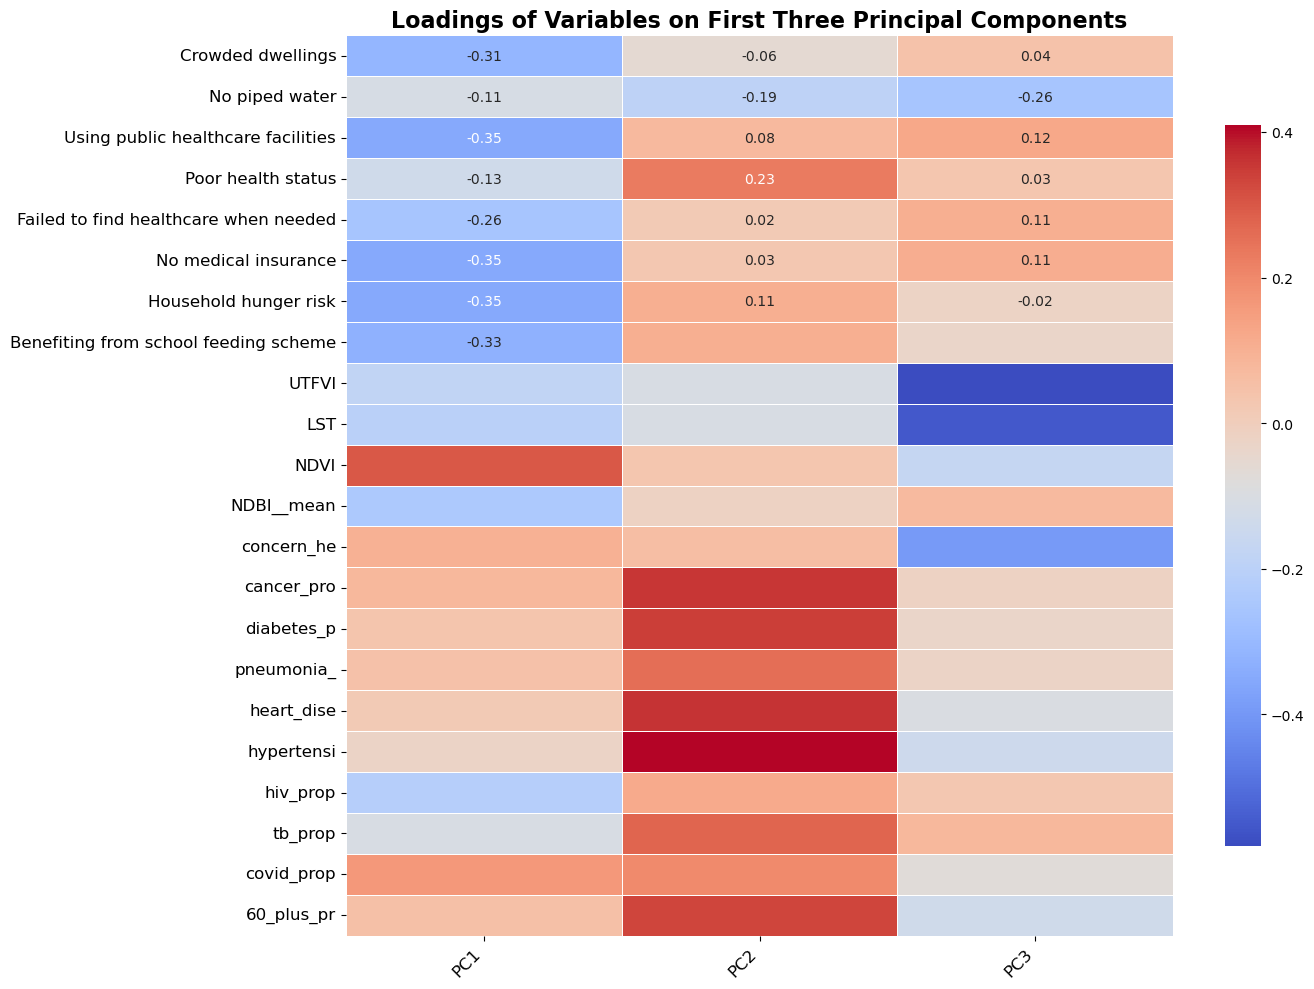

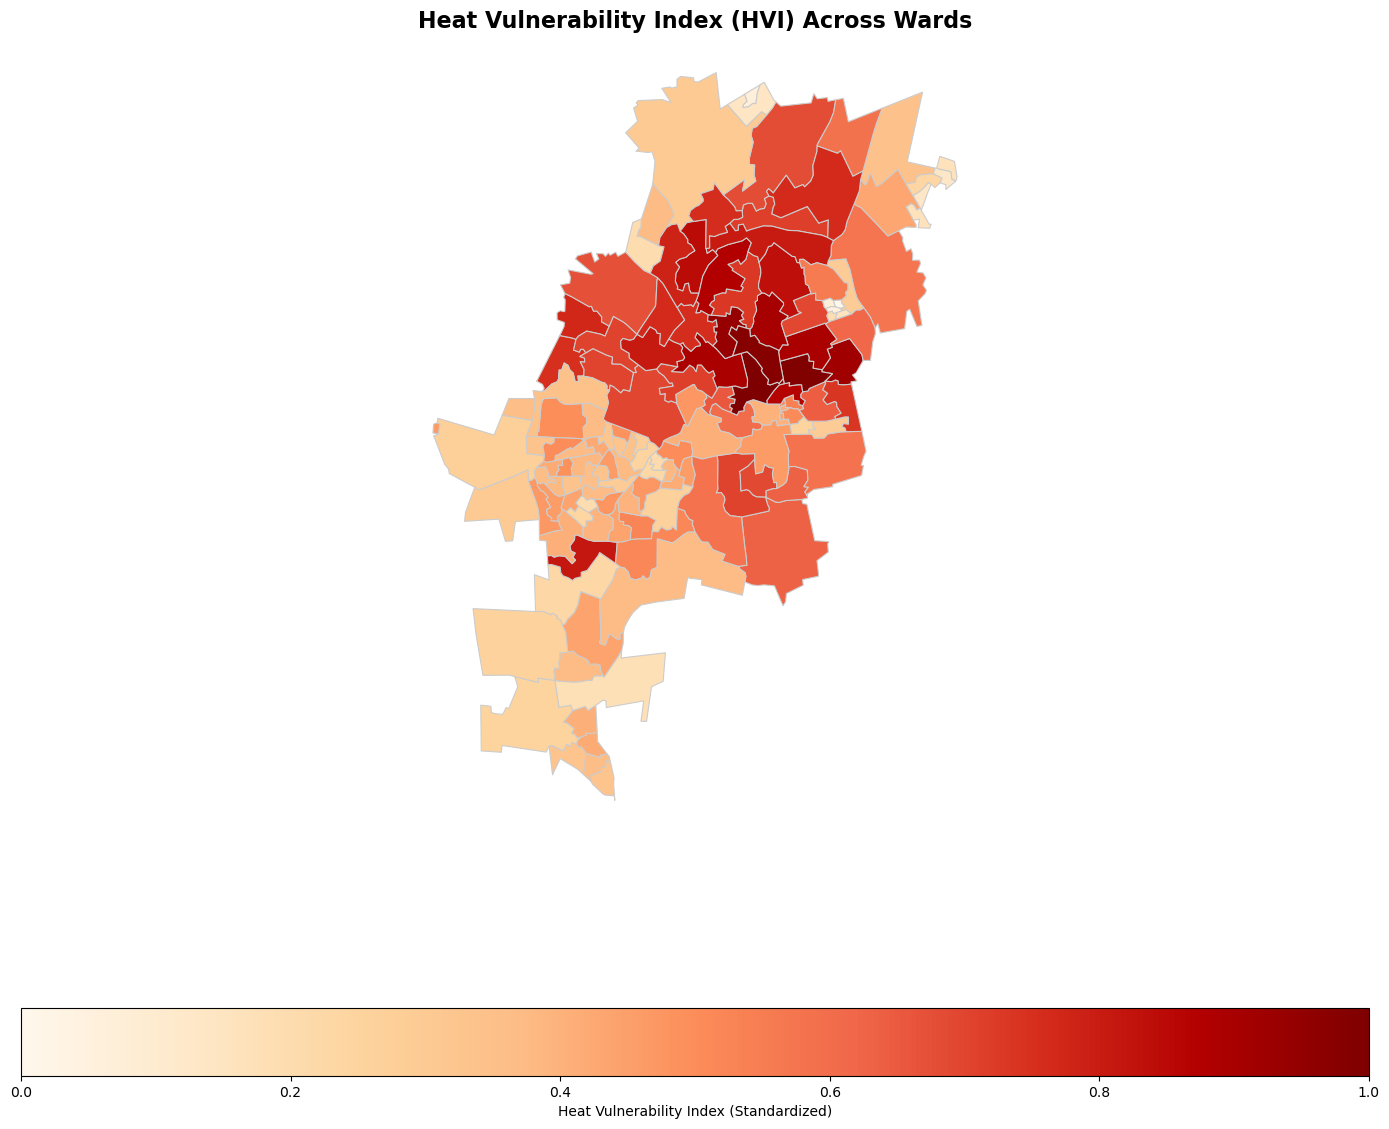

C:\Users\CraigParker\AppData\Local\Temp\ipykernel_32152\1799700460.py:154: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(fontsize=12)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


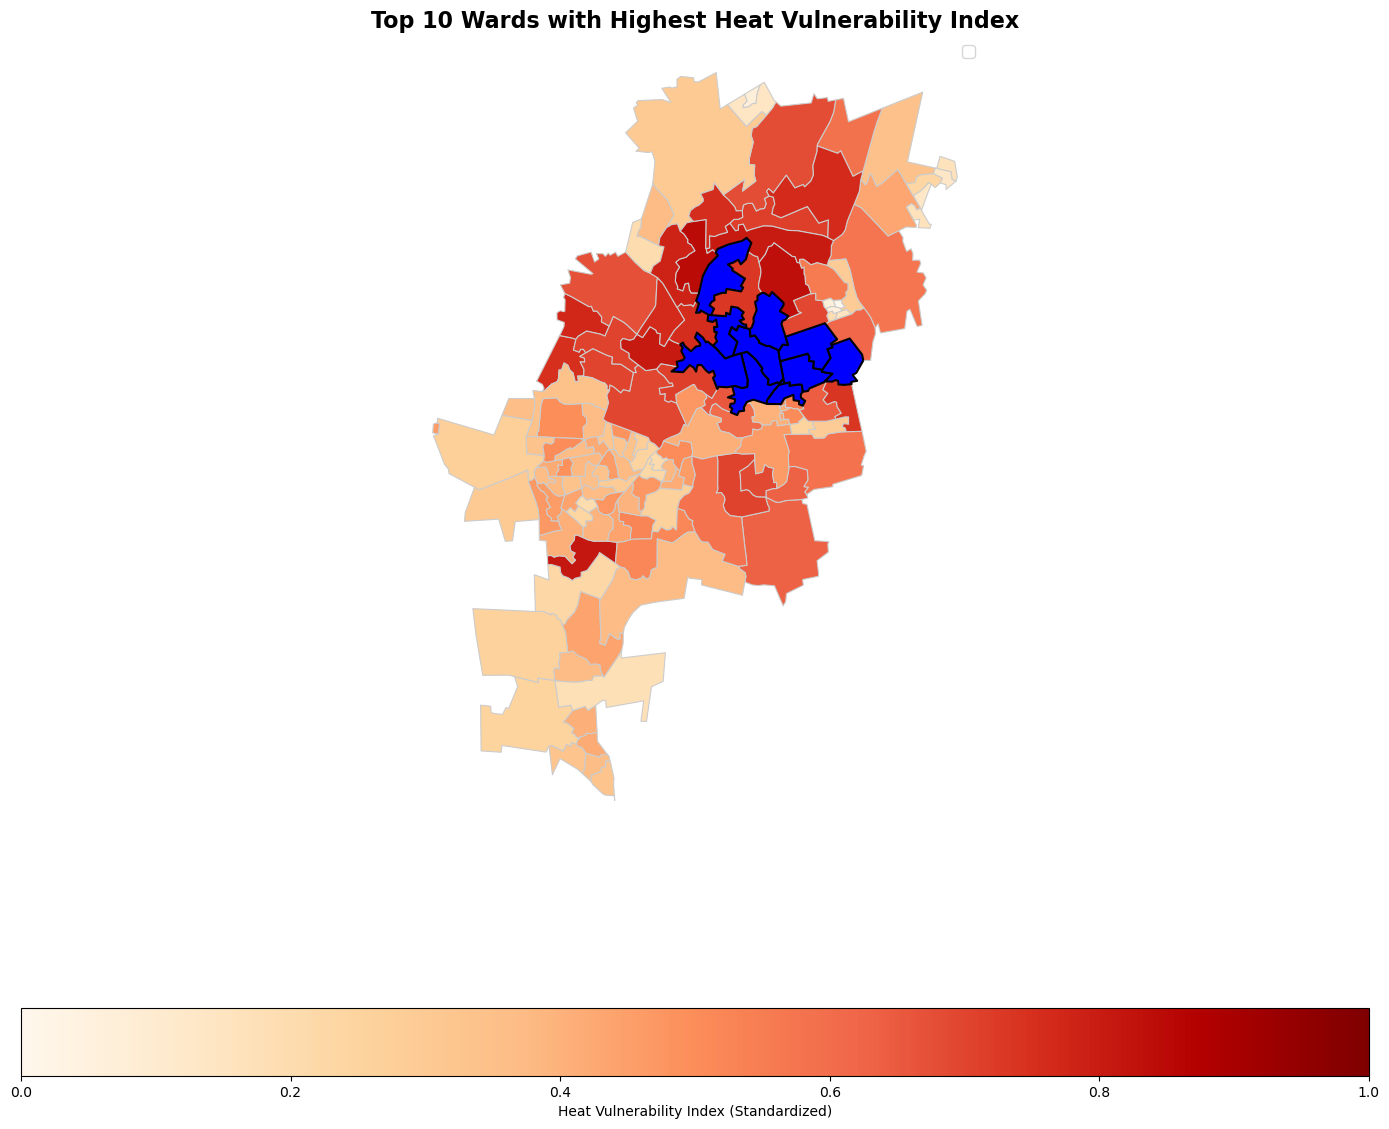

Top 10 Vulnerable Wards:
      WardID_  HVI_weighted_standardized
86   79800087                   1.000000
73   79800073                   0.995599
116  79800117                   0.984097
98   79800099                   0.944253
72   79800072                   0.921102
89   79800090                   0.905557
74   79800074                   0.893363
87   79800088                   0.892488
103  79800104                   0.876396
67   79800067                   0.865001


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the GeoJSON file using GeoPandas
file_path = 'HVI_with_columnames.geojson'  # Replace with your actual file path
gdf = gpd.read_file(file_path)

# Convert multi-part geometries into single-part geometries if necessary
gdf = gdf.explode(index_parts=False).reset_index(drop=True)

# Display the first few rows
gdf.head()

variables = [
    'Crowded dwellings', 'No piped water', 'Using public healthcare facilities', 'Poor health status',
    'Failed to find healthcare when needed', 'No medical insurance', 'Household hunger risk',
    'Benefiting from school feeding scheme', 'UTFVI', 'LST', 'NDVI', 'NDBI__mean', 'concern_he',
    'cancer_pro', 'diabetes_p', 'pneumonia_', 'heart_dise', 'hypertensi', 'hiv_prop', 'tb_prop',
    'covid_prop', '60_plus_pr'
]

# Check for missing values
missing_values = gdf[variables].isnull().sum()
print("Missing values in each variable:")
print(missing_values)

# Convert variables to numeric if necessary
for var in variables:
    gdf[var] = pd.to_numeric(gdf[var], errors='coerce')

# Re-check for missing values after conversion
missing_values = gdf[variables].isnull().sum()
print("Missing values after type conversion:")
print(missing_values)

# For simplicity, drop rows with missing values
gdf_clean = gdf.dropna(subset=variables).copy()
print(f"Number of rows after dropping missing values: {gdf_clean.shape[0]}")

# Descriptive statistics of the variables
desc_stats = gdf_clean[variables].describe()
print(desc_stats)

# Save the descriptive statistics to a CSV file
desc_stats.to_csv('Descriptive_Statistics.csv')

# Compute the correlation matrix
corr_matrix = gdf_clean[variables].corr()

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8}, annot_kws={'size': 10})
plt.title('Correlation Matrix of Variables', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Save the correlation matrix
corr_matrix.to_csv('Correlation_Matrix.csv')

# Standardize the variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(gdf_clean[variables])

# Initialize PCA
pca = PCA(n_components=None)
principal_components = pca.fit_transform(scaled_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Determine the number of components explaining 90% variance
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components explaining 90% variance: {n_components}")

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance * 100, marker='o', linestyle='--', color='b', linewidth=2)
plt.title('Scree Plot', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', linestyle='-', color='g', linewidth=2)
plt.title('Cumulative Explained Variance', fontsize=16, fontweight='bold')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Variance Explained (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Get the loadings (coefficients)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(explained_variance))], index=variables)

# Display the loadings for the first three principal components
loadings_first_three = loadings[['PC1', 'PC2', 'PC3']]
print(loadings_first_three)

# Heatmap of loadings for the first three PCs
plt.figure(figsize=(14, 10))
sns.heatmap(loadings_first_three, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8}, annot_kws={'size': 10})
plt.title('Loadings of Variables on First Three Principal Components', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Add PC1 to the GeoDataFrame
gdf_clean['HVI_PC1'] = principal_components[:, 0]

# Standardize HVI_PC1
gdf_clean['HVI_PC1_standardized'] = (gdf_clean['HVI_PC1'] - gdf_clean['HVI_PC1'].min()) / (gdf_clean['HVI_PC1'].max() - gdf_clean['HVI_PC1'].min())

# Use the first n_components that explain 90% variance
weights = explained_variance[:n_components]
gdf_clean['HVI_weighted'] = principal_components[:, :n_components] @ weights

# Standardize the weighted HVI
gdf_clean['HVI_weighted_standardized'] = (gdf_clean['HVI_weighted'] - gdf_clean['HVI_weighted'].min()) / (gdf_clean['HVI_weighted'].max() - gdf_clean['HVI_weighted'].min())

# Plot HVI across wards
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
gdf_clean.plot(column='HVI_weighted_standardized', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Heat Vulnerability Index (Standardized)", 'orientation': "horizontal"})
plt.title('Heat Vulnerability Index (HVI) Across Wards', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Identify top 10 vulnerable wards
top_10_wards = gdf_clean.nlargest(10, 'HVI_weighted_standardized')

# Plot the map with top 10 wards highlighted
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
gdf_clean.plot(column='HVI_weighted_standardized', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Heat Vulnerability Index (Standardized)", 'orientation': "horizontal"})
top_10_wards.plot(ax=ax, color='blue', edgecolor='black', linewidth=1.5, label='Top 10 Vulnerable Wards')
plt.title('Top 10 Wards with Highest Heat Vulnerability Index', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Display top 10 wards
print("Top 10 Vulnerable Wards:")
print(top_10_wards[['WardID_', 'HVI_weighted_standardized']])

Missing values in each variable:
Crowded dwellings                        0
No piped water                           0
Using public healthcare facilities       0
Poor health status                       0
Failed to find healthcare when needed    0
No medical insurance                     0
Household hunger risk                    0
Benefiting from school feeding scheme    0
UTFVI                                    0
LST                                      0
NDVI                                     0
NDBI__mean                               0
concern_he                               0
cancer_pro                               0
diabetes_p                               0
pneumonia_                               0
heart_dise                               0
hypertensi                               0
hiv_prop                                 0
tb_prop                                  0
covid_prop                               0
60_plus_pr                               0
dtype: int64
Missing 

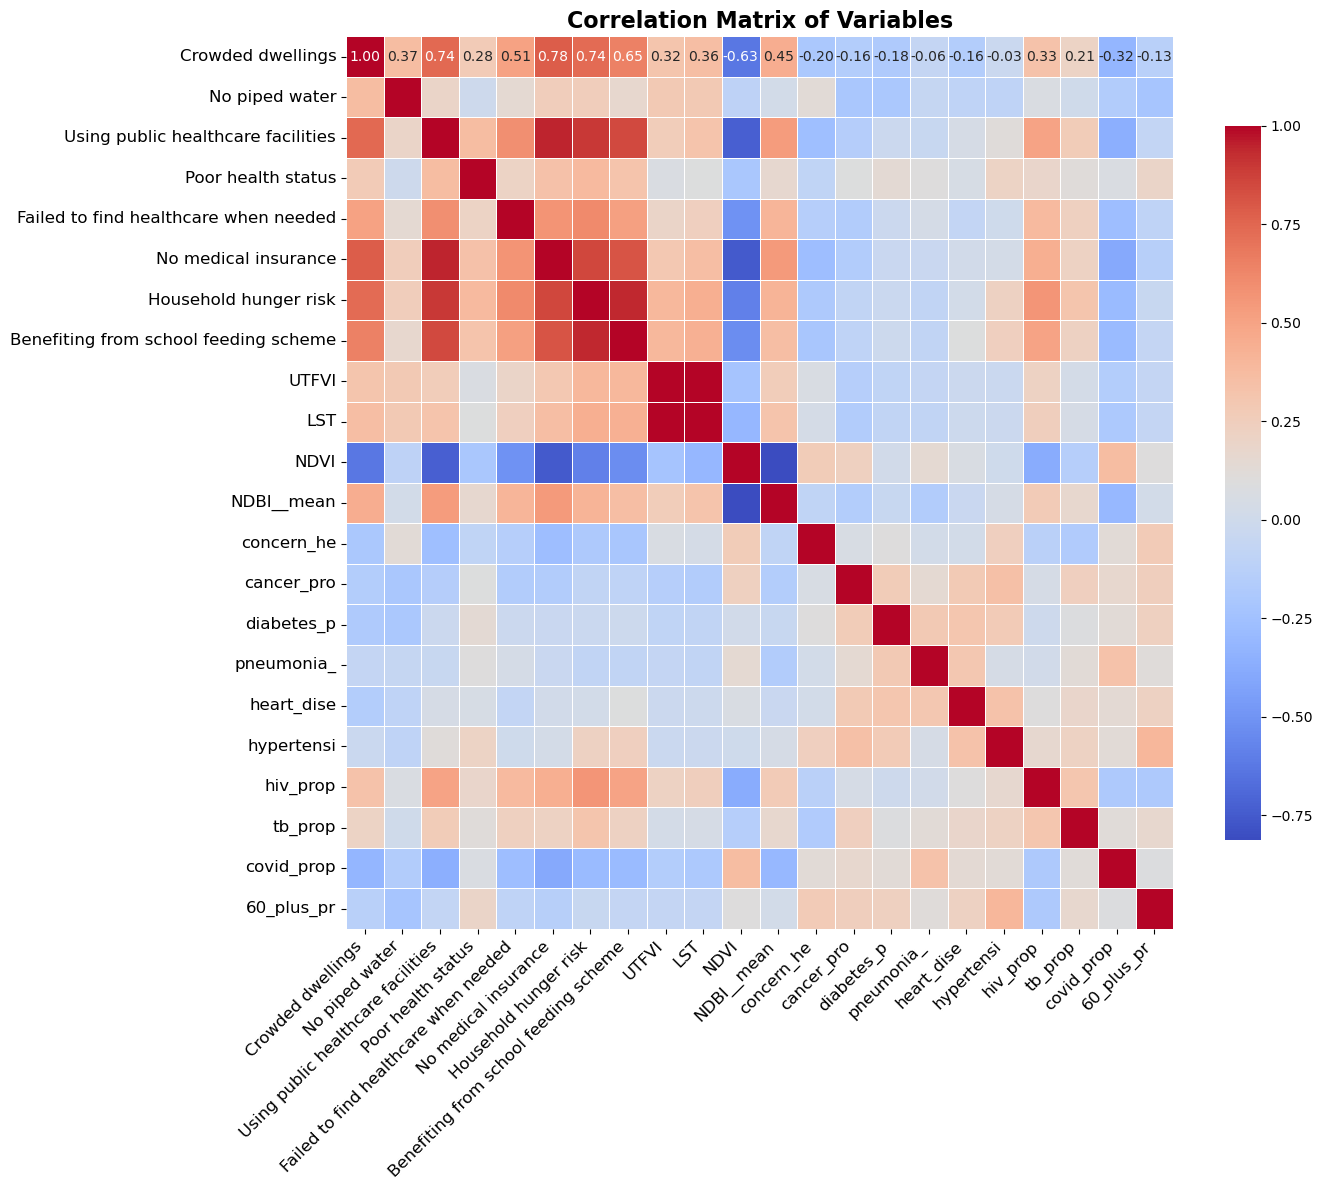

Number of components explaining 90% variance: 13


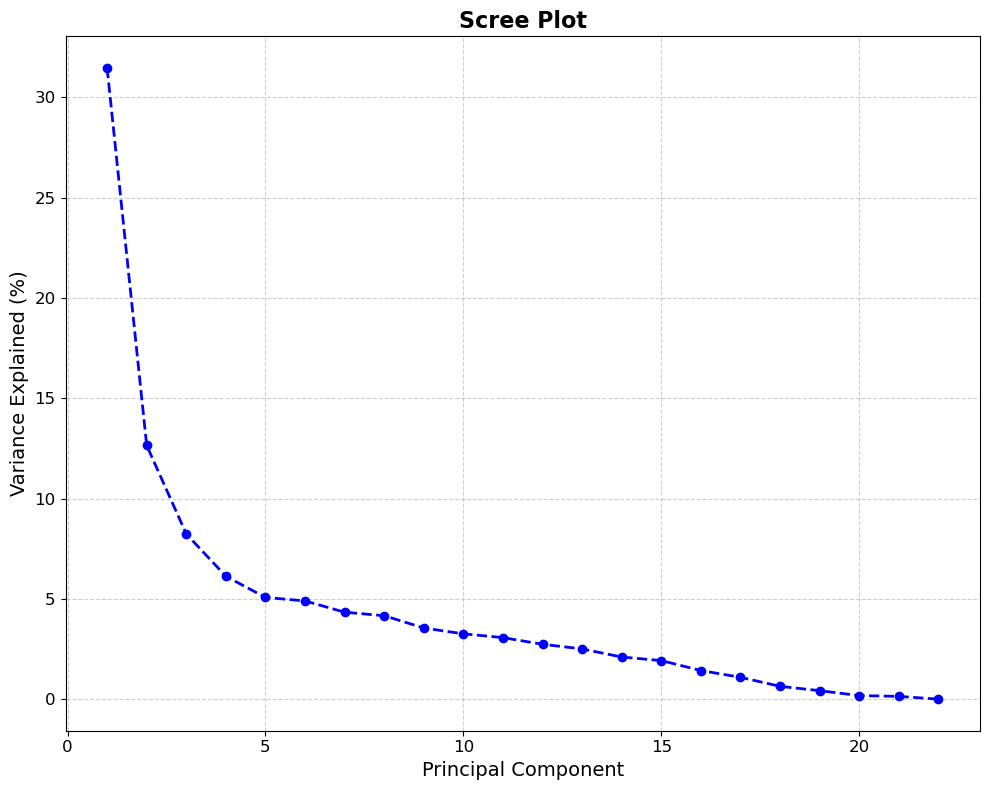

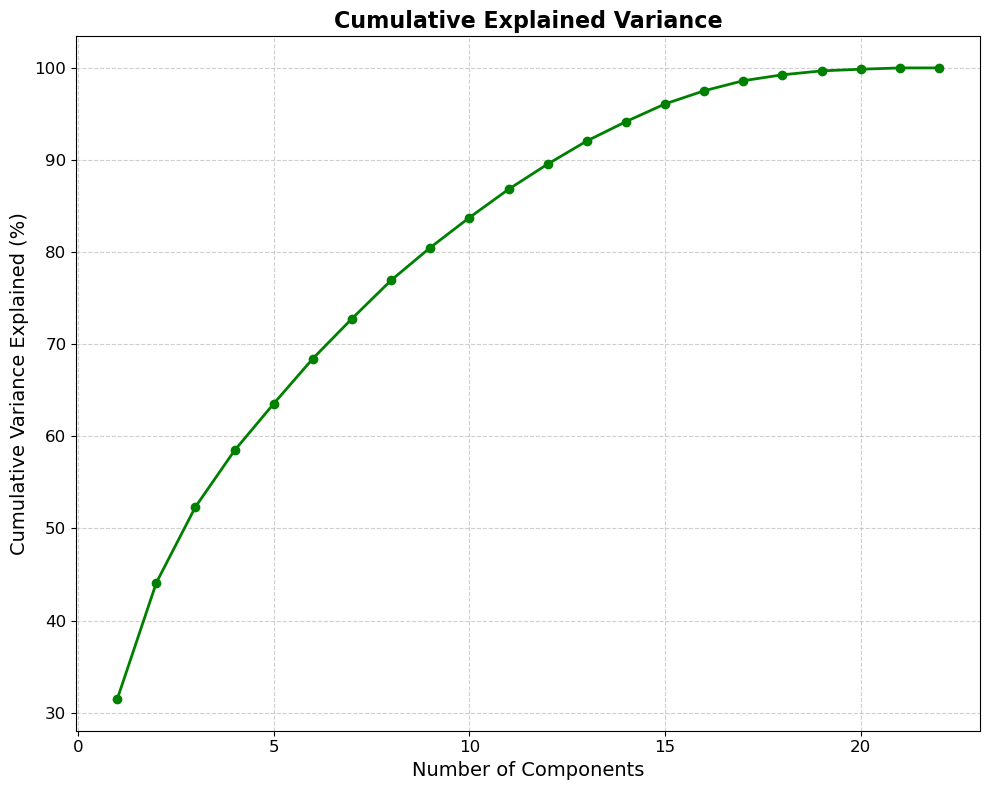

                                            PC1       PC2       PC3
Crowded dwellings                     -0.310918 -0.056326  0.042989
No piped water                        -0.112483 -0.191059 -0.256855
Using public healthcare facilities    -0.352105  0.076542  0.123018
Poor health status                    -0.132356  0.230866  0.032982
Failed to find healthcare when needed -0.256746  0.016471  0.106190
No medical insurance                  -0.351050  0.026580  0.109180
Household hunger risk                 -0.349229  0.106490 -0.022795
Benefiting from school feeding scheme -0.326710  0.106338 -0.034114
UTFVI                                 -0.181751 -0.107997 -0.580553
LST                                   -0.205122 -0.105668 -0.552797
NDVI                                   0.300604  0.033316 -0.167401
NDBI__mean                            -0.240871 -0.017188  0.069503
concern_he                             0.098298  0.061004 -0.391323
cancer_pro                             0.077956 

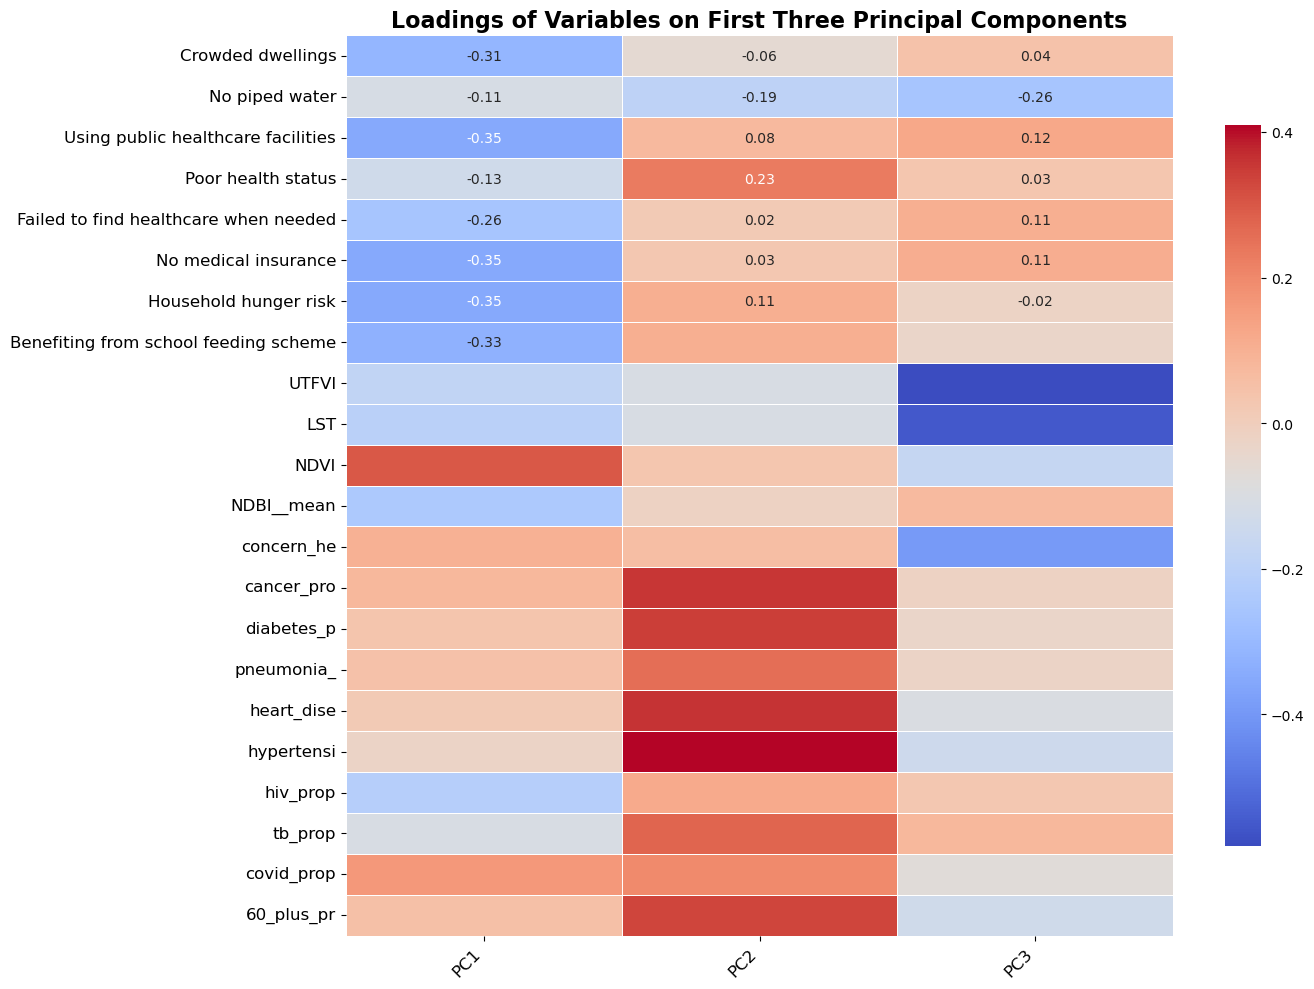

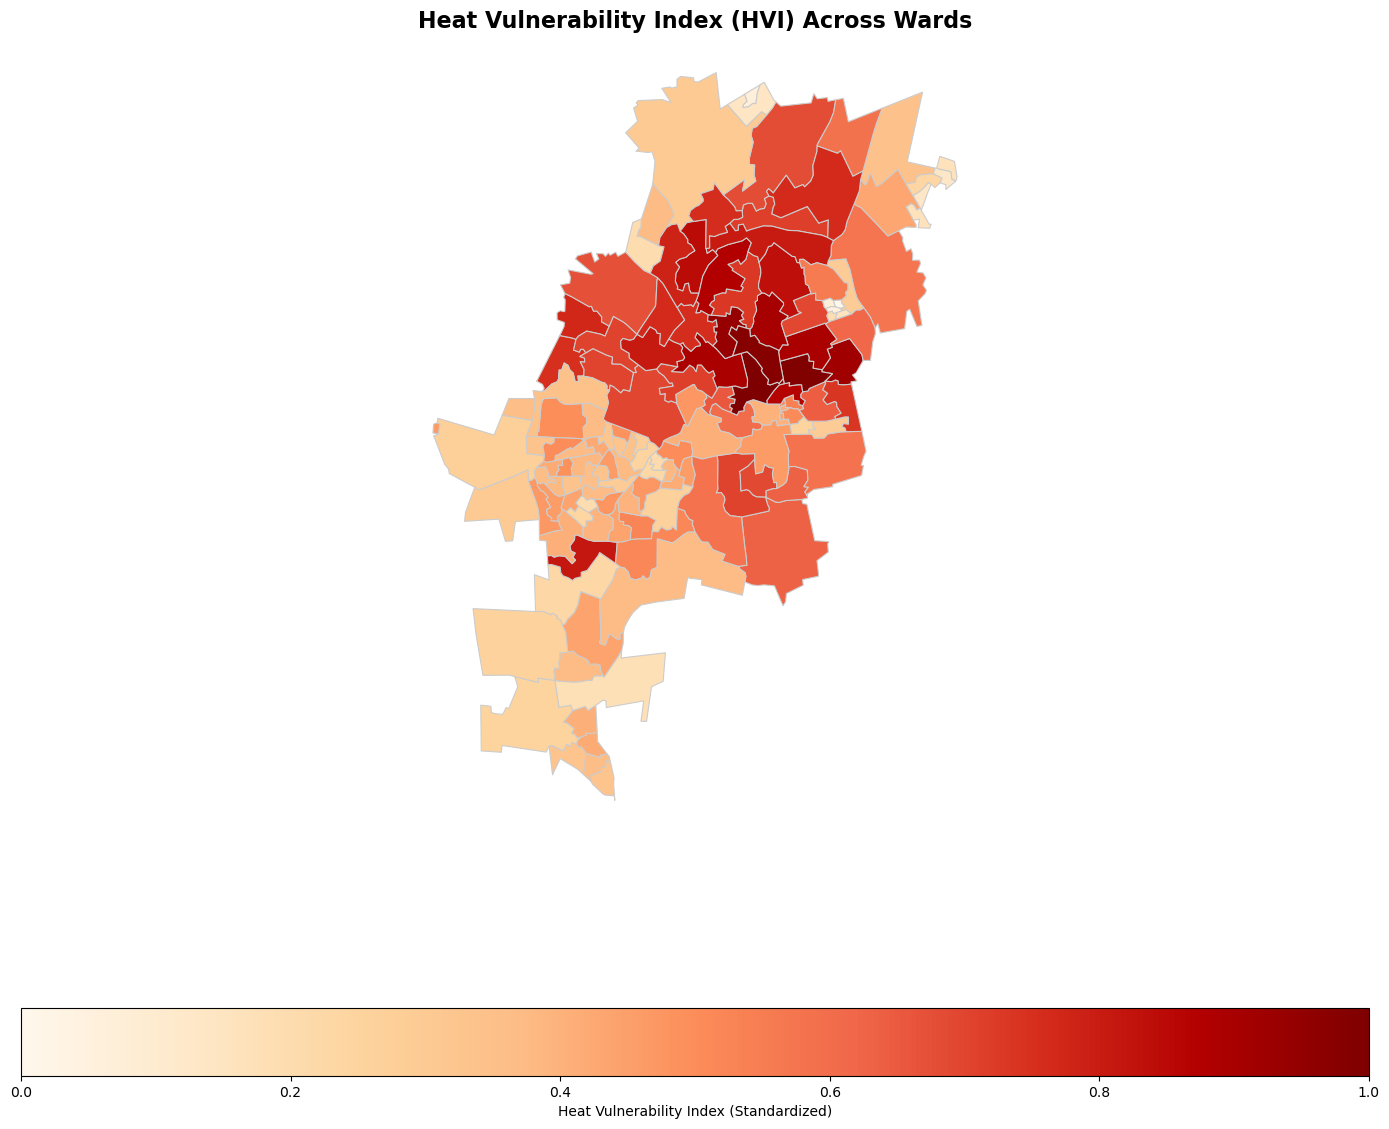

C:\Users\CraigParker\AppData\Local\Temp\ipykernel_36488\2733965646.py:156: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(fontsize=12)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


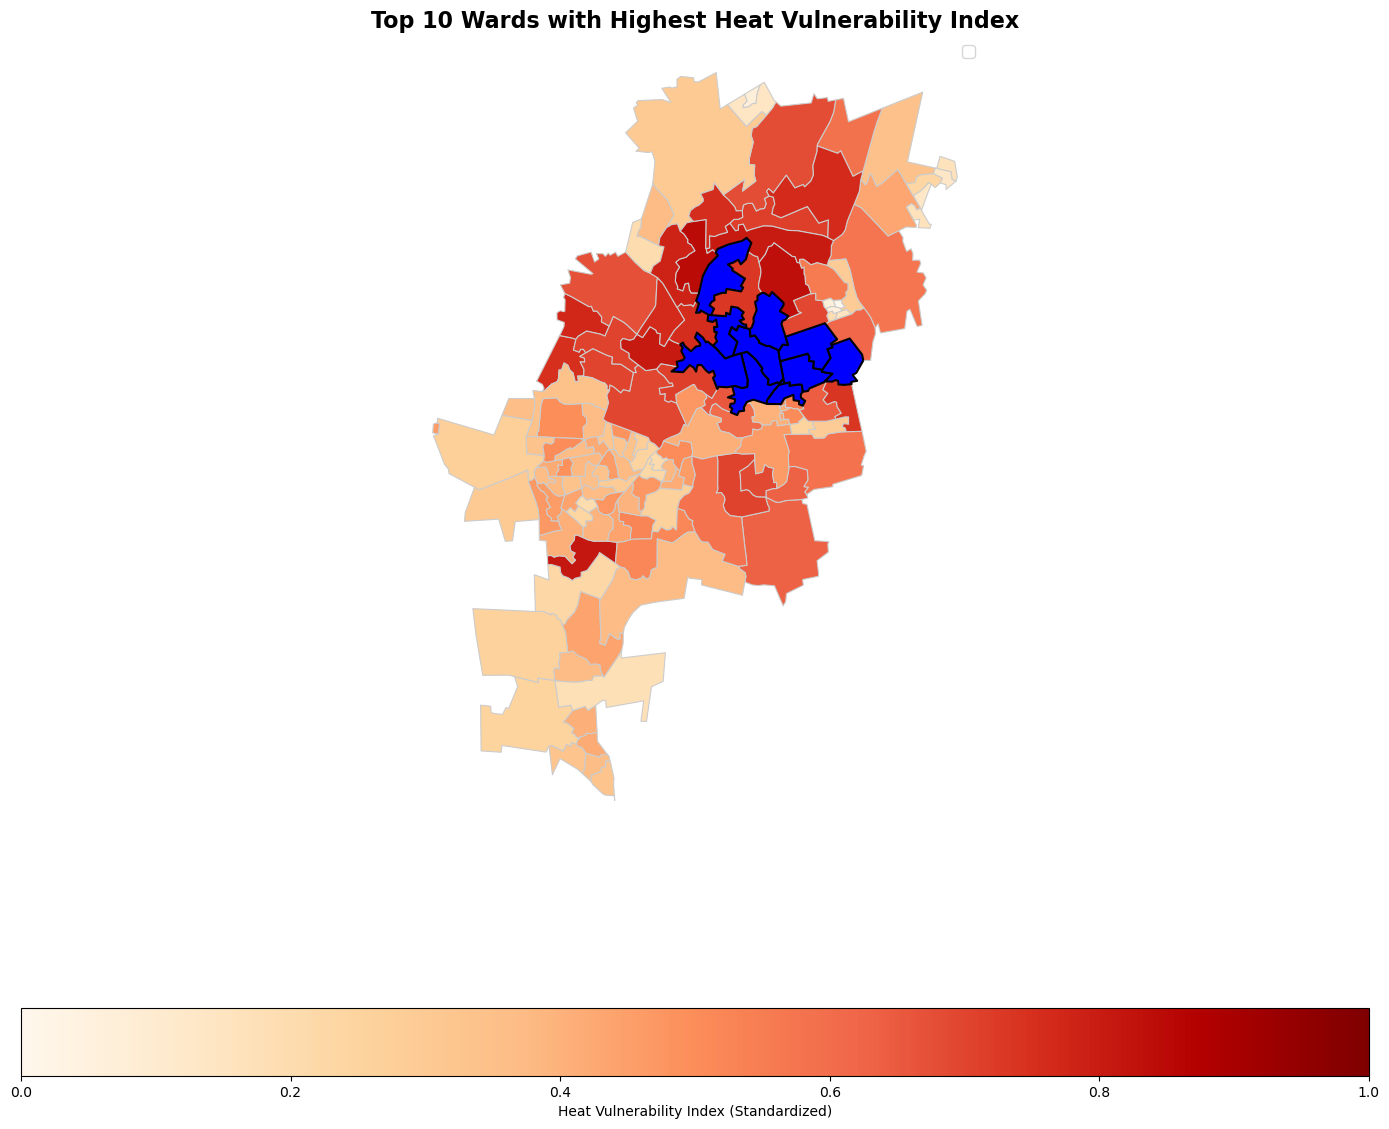

Top 10 Vulnerable Wards:
      WardID_  HVI_weighted_standardized
86   79800087                   1.000000
73   79800073                   0.995599
116  79800117                   0.984097
98   79800099                   0.944253
72   79800072                   0.921102
89   79800090                   0.905557
74   79800074                   0.893363
87   79800088                   0.892488
103  79800104                   0.876396
67   79800067                   0.865001


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_36488\2733965646.py:174: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='TSNE_1', y='TSNE_2', data=gdf_clean, palette='viridis', edgecolor='k', alpha=0.7)


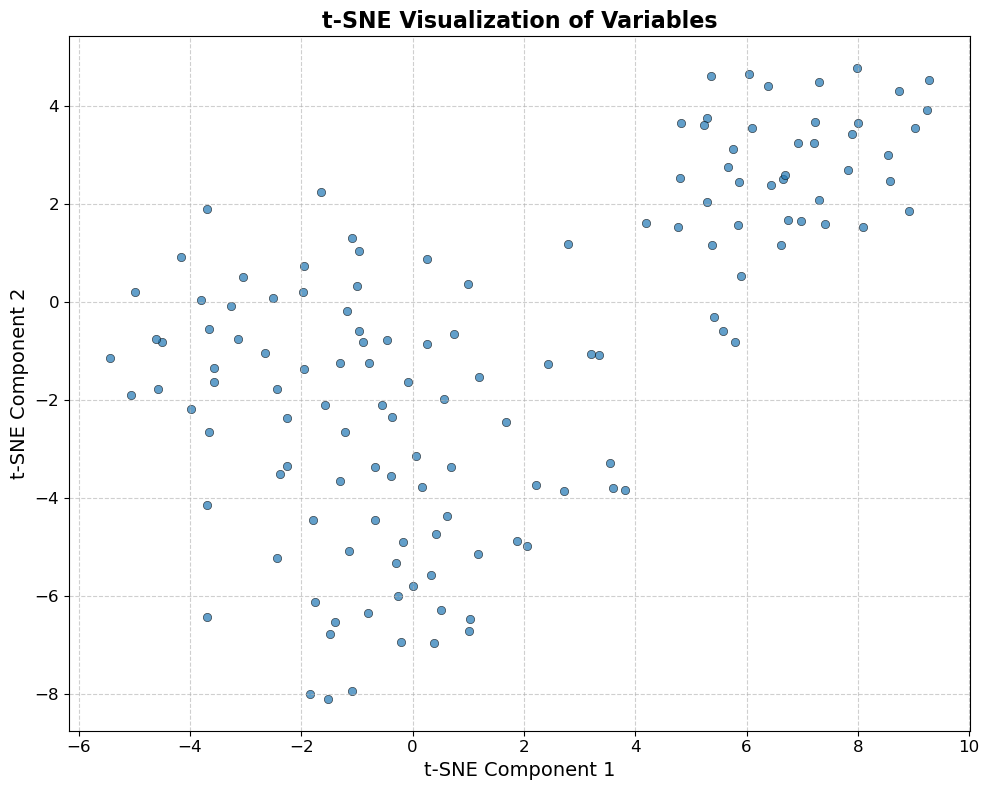

c:\Users\craigparker\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\craigparker\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


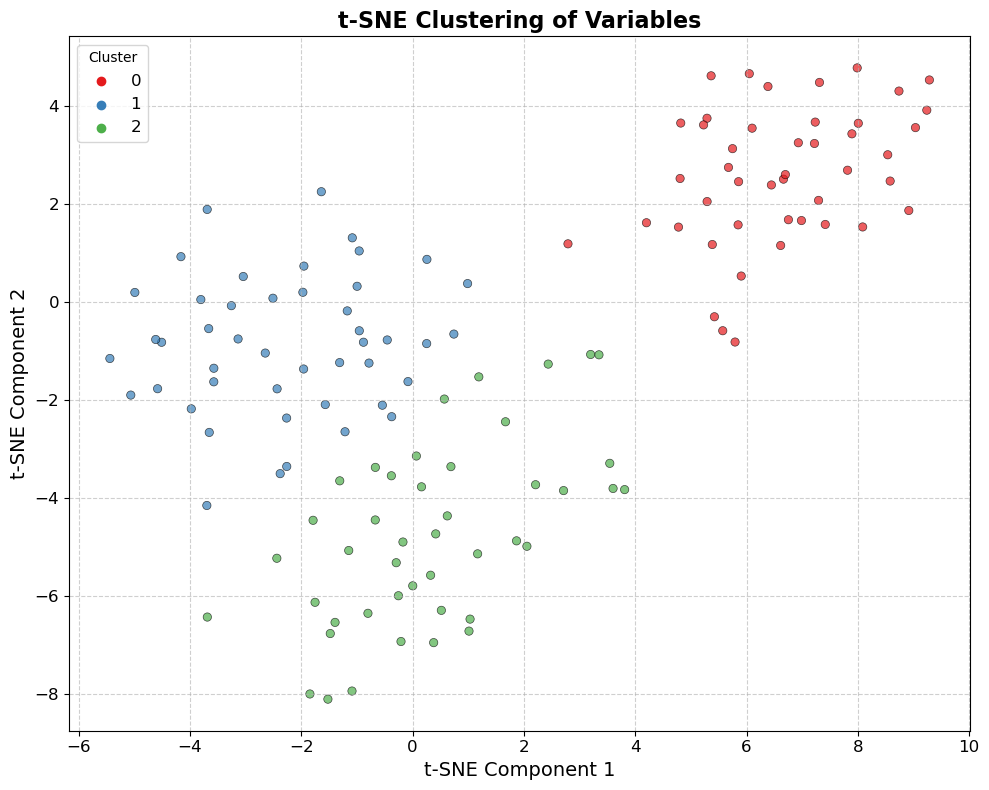

Cluster 0 Mean Values:
concern_he                               50.422640
No medical insurance                     29.947333
LST                                      27.172690
Using public healthcare facilities       22.508222
Household hunger risk                     7.119111
Benefiting from school feeding scheme     6.701333
Poor health status                        5.094889
cancer_pro                                4.302136
No piped water                            2.420444
Crowded dwellings                         2.346000
Failed to find healthcare when needed     1.524667
NDBI__mean                                0.334827
NDVI                                      0.175219
hypertensi                                0.002125
diabetes_p                                0.001273
60_plus_pr                                0.001026
covid_prop                                0.000601
heart_dise                                0.000531
hiv_prop                                  0.000325
tb_prop 

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Load the GeoJSON file using GeoPandas
file_path = 'HVI_with_columnames.geojson'  # Replace with your actual file path
gdf = gpd.read_file(file_path)

# Convert multi-part geometries into single-part geometries if necessary
gdf = gdf.explode(index_parts=False).reset_index(drop=True)

# Display the first few rows
gdf.head()

variables = [
    'Crowded dwellings', 'No piped water', 'Using public healthcare facilities', 'Poor health status',
    'Failed to find healthcare when needed', 'No medical insurance', 'Household hunger risk',
    'Benefiting from school feeding scheme', 'UTFVI', 'LST', 'NDVI', 'NDBI__mean', 'concern_he',
    'cancer_pro', 'diabetes_p', 'pneumonia_', 'heart_dise', 'hypertensi', 'hiv_prop', 'tb_prop',
    'covid_prop', '60_plus_pr'
]

# Check for missing values
missing_values = gdf[variables].isnull().sum()
print("Missing values in each variable:")
print(missing_values)

# Convert variables to numeric if necessary
for var in variables:
    gdf[var] = pd.to_numeric(gdf[var], errors='coerce')

# Re-check for missing values after conversion
missing_values = gdf[variables].isnull().sum()
print("Missing values after type conversion:")
print(missing_values)

# For simplicity, drop rows with missing values
gdf_clean = gdf.dropna(subset=variables).copy()
print(f"Number of rows after dropping missing values: {gdf_clean.shape[0]}")

# Descriptive statistics of the variables
desc_stats = gdf_clean[variables].describe()
print(desc_stats)

# Save the descriptive statistics to a CSV file
desc_stats.to_csv('Descriptive_Statistics.csv')

# Compute the correlation matrix
corr_matrix = gdf_clean[variables].corr()

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8}, annot_kws={'size': 10})
plt.title('Correlation Matrix of Variables', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Save the correlation matrix
corr_matrix.to_csv('Correlation_Matrix.csv')

# Standardize the variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(gdf_clean[variables])

# Initialize PCA
pca = PCA(n_components=None)
principal_components = pca.fit_transform(scaled_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Determine the number of components explaining 90% variance
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components explaining 90% variance: {n_components}")

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance * 100, marker='o', linestyle='--', color='b', linewidth=2)
plt.title('Scree Plot', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', linestyle='-', color='g', linewidth=2)
plt.title('Cumulative Explained Variance', fontsize=16, fontweight='bold')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Variance Explained (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Get the loadings (coefficients)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(explained_variance))], index=variables)

# Display the loadings for the first three principal components
loadings_first_three = loadings[['PC1', 'PC2', 'PC3']]
print(loadings_first_three)

# Heatmap of loadings for the first three PCs
plt.figure(figsize=(14, 10))
sns.heatmap(loadings_first_three, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8}, annot_kws={'size': 10})
plt.title('Loadings of Variables on First Three Principal Components', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Add PC1 to the GeoDataFrame
gdf_clean['HVI_PC1'] = principal_components[:, 0]

# Standardize HVI_PC1
gdf_clean['HVI_PC1_standardized'] = (gdf_clean['HVI_PC1'] - gdf_clean['HVI_PC1'].min()) / (gdf_clean['HVI_PC1'].max() - gdf_clean['HVI_PC1'].min())

# Use the first n_components that explain 90% variance
weights = explained_variance[:n_components]
gdf_clean['HVI_weighted'] = principal_components[:, :n_components] @ weights

# Standardize the weighted HVI
gdf_clean['HVI_weighted_standardized'] = (gdf_clean['HVI_weighted'] - gdf_clean['HVI_weighted'].min()) / (gdf_clean['HVI_weighted'].max() - gdf_clean['HVI_weighted'].min())

# Plot HVI across wards
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
gdf_clean.plot(column='HVI_weighted_standardized', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Heat Vulnerability Index (Standardized)", 'orientation': "horizontal"})
plt.title('Heat Vulnerability Index (HVI) Across Wards', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Identify top 10 vulnerable wards
top_10_wards = gdf_clean.nlargest(10, 'HVI_weighted_standardized')

# Plot the map with top 10 wards highlighted
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
gdf_clean.plot(column='HVI_weighted_standardized', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Heat Vulnerability Index (Standardized)", 'orientation': "horizontal"})
top_10_wards.plot(ax=ax, color='blue', edgecolor='black', linewidth=1.5, label='Top 10 Vulnerable Wards')
plt.title('Top 10 Wards with Highest Heat Vulnerability Index', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Display top 10 wards
print("Top 10 Vulnerable Wards:")
print(top_10_wards[['WardID_', 'HVI_weighted_standardized']])

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)

# Add t-SNE results to the GeoDataFrame
gdf_clean['TSNE_1'] = tsne_results[:, 0]
gdf_clean['TSNE_2'] = tsne_results[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE_1', y='TSNE_2', data=gdf_clean, palette='viridis', edgecolor='k', alpha=0.7)
plt.title('t-SNE Visualization of Variables', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Cluster the t-SNE results to identify potential drivers of vulnerability
kmeans = KMeans(n_clusters=3, random_state=42)
gdf_clean['tSNE_Cluster'] = kmeans.fit_predict(tsne_results)

# Plot t-SNE with clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE_1', y='TSNE_2', data=gdf_clean, hue='tSNE_Cluster', palette='Set1', edgecolor='k', alpha=0.7)
plt.title('t-SNE Clustering of Variables', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze the clusters to identify key drivers of vulnerability
for cluster in range(kmeans.n_clusters):
    cluster_data = gdf_clean[gdf_clean['tSNE_Cluster'] == cluster]
    cluster_mean = cluster_data[variables].mean()
    print(f"Cluster {cluster} Mean Values:")
    print(cluster_mean.sort_values(ascending=False))
    print("\n")